# File and libraries

In [101]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


filepath=r'dataset/df_ecom_2_2_mv_input_v2_dummyfication.csv'


file_tag = "df_ecom_outlier_input"

# DSLabs functions

In [102]:
%run "dslabs_functions.py"


data_functions lodaded


# Data functions

In [103]:
%run "data_functions.py"


data_functions lodaded


# Load

In [104]:
# test_data=True
test_data=False

if test_data==True:

    df=pd.read_csv(filepath)

    # 1% sample
    df=df.sample(frac=0.01, replace=False)
    

else:
    df=pd.read_csv(filepath)
    # 50% sample
    # data=data.sample(frac=0.5, replace=False)

 
target='is_purchase'

# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
df.sort_values(by='day', inplace=True)



df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177828 entries, 0 to 177827
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   category_code_lvl_1  177828 non-null  float64
 1   category_code_lvl_2  177828 non-null  float64
 2   category_code_lvl_3  177828 non-null  float64
 3   price                177828 non-null  float64
 4   week_of_month        177828 non-null  int64  
 5   is_weekend           177828 non-null  int64  
 6   day                  177828 non-null  int64  
 7   is_view              177828 non-null  int64  
 8   is_cart              177828 non-null  int64  
 9   is_purchase          177828 non-null  int64  
 10  time_of_day_sin      177828 non-null  float64
 11  time_of_day_cos      177828 non-null  float64
 12  day_of_week_sin      177828 non-null  float64
 13  day_of_week_cos      177828 non-null  float64
 14  hour_sin             177828 non-null  float64
 15  hour_cos             1

In [105]:
df.head()

,category_code_lvl_1,category_code_lvl_2,category_code_lvl_3,price,week_of_month,is_weekend,day,is_view,is_cart,is_purchase,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,min_sin,min_cos
0,6.0,42.0,102.0,128.45,0,0,0,1,0,0,0.0,1.0,1.0,0.0,0.817,-0.577,-0.000,1.000
2836,0.0,6.0,10.0,770.93,0,0,0,1,0,0,0.0,-1.0,1.0,0.0,-0.631,-0.776,0.899,-0.437
2837,0.0,0.0,2.0,316.53,0,0,0,1,0,0,0.0,1.0,1.0,0.0,0.398,-0.917,0.991,-0.133
2838,11.0,57.0,125.0,127.29,0,0,0,1,0,0,0.0,-1.0,1.0,0.0,-0.631,-0.776,1.000,-0.027
2839,5.0,38.0,90.0,743.91,0,0,0,1,0,0,0.0,-1.0,1.0,0.0,-0.998,-0.068,-0.638,-0.770


# Outlier Analysis

- These are the only numeric columns that has outliers that need to be treated:
    - price
    - hour_cos


In [106]:
from dslabs_functions import get_variable_types

variable_types: dict[str, list] = get_variable_types(df)
print(variable_types)

{'numeric': ['category_code_lvl_1', 'category_code_lvl_2', 'category_code_lvl_3', 'price', 'week_of_month', 'day', 'time_of_day_sin', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos'], 'binary': ['is_weekend', 'is_view', 'is_cart', 'is_purchase', 'time_of_day_cos'], 'date': [], 'symbolic': []}


# Summary5 and var selection

#### Checking outliers

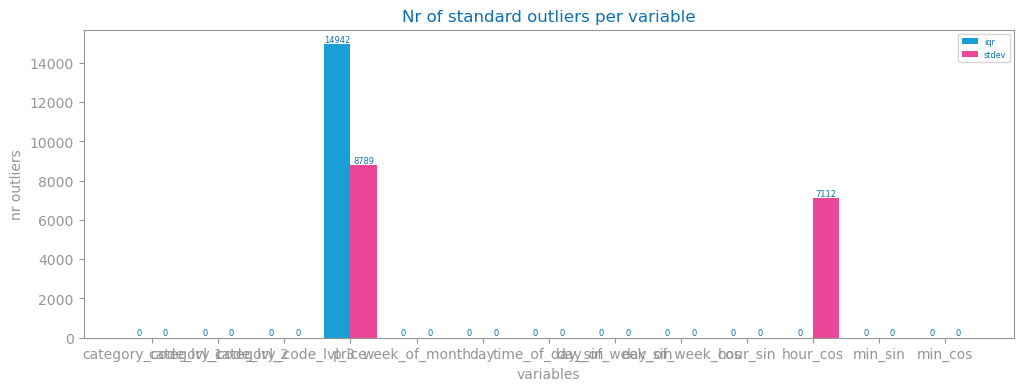

In [107]:
from pandas import Series
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_multibar_chart

#This is the number of times * Standartdeviation.  
#Outliers are defined as values that are a certain distance from the mean, determined by the number of standard deviations you specified
#the higher the nr_stdev_ less outliers ww will have
NR_STDEV: int = 2


IQR_FACTOR: float = 1.5


def determine_outlier_thresholds_for_var(
    summary5: Series, std_based: bool = True, threshold: float = NR_STDEV
) -> tuple[float, float]:
    top: float = 0
    bottom: float = 0
    if std_based:
        std: float = threshold * summary5["std"]
        top = summary5["mean"] + std
        bottom = summary5["mean"] - std
    else:
        iqr: float = threshold * (summary5["75%"] - summary5["25%"])
        top = summary5["75%"] + iqr
        bottom = summary5["25%"] - iqr

    return top, bottom



def count_outliers(
    data: DataFrame,
    numeric: list[str],
    nrstdev: int = NR_STDEV,
    iqrfactor: float = IQR_FACTOR,
) -> dict:
    outliers_iqr: list = []
    outliers_stdev: list = []
    summary5: DataFrame = df[numeric].describe()

    for var in numeric:
        top: float
        bottom: float
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=True, threshold=nrstdev
        )
        outliers_stdev += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=False, threshold=iqrfactor
        )
        outliers_iqr += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

    return {"iqr": outliers_iqr, "stdev": outliers_stdev}

# Usar a função get_variable_types() para obter as variáveis numéricas
variable_types: dict[str, list] = get_variable_types(df)
numeric: list[str] = variable_types["numeric"]


if [] != numeric:
    outliers: dict[str, int] = count_outliers(df, numeric)
    figure(figsize=(12, HEIGHT))
    plot_multibar_chart(
        numeric,
        outliers,
        title="Nr of standard outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    #savefig(f"images/{file_tag}_outliers_standard.png")
    show()
else:
    print("There are no numeric variables.")

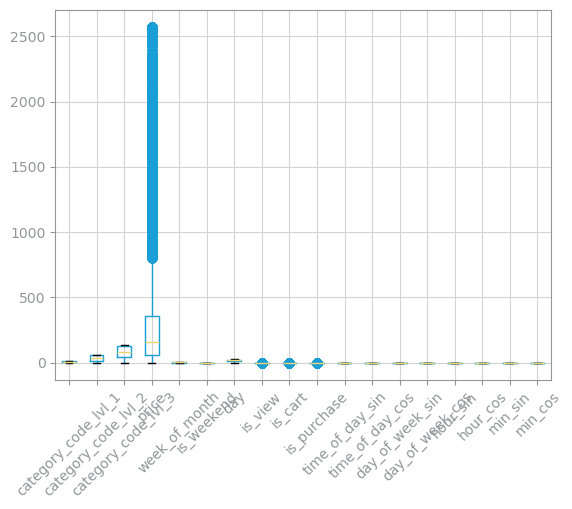

In [108]:
from matplotlib.pyplot import savefig, show


df.boxplot(rot=45)
# savefig(f"{file_tag}_global_boxplot.png")
show()


# Summary5 and var selection

In [23]:

# Analisar a variável 'price'
var_price = 'price'
summary_price: DataFrame = df[[var_price]].describe(include="all")
print("Summary for 'price':")
print(summary_price)

# Analisar a variável 'hour'
var_hour = 'hour_cos'
summary_hour: DataFrame = df[[var_hour]].describe(include="all")
print("Summary for 'hour':")
print(summary_hour)


Summary for 'price':
               price
count  177828.000000
mean      279.285401
std       357.068768
min         0.000000
25%        55.187500
50%       154.420000
75%       354.450000
max      2574.070000
Summary for 'hour':
            hour_cos
count  177828.000000
mean       -0.266491
std         0.605393
min        -0.991000
25%        -0.776000
50%        -0.335000
75%         0.203000
max         1.000000


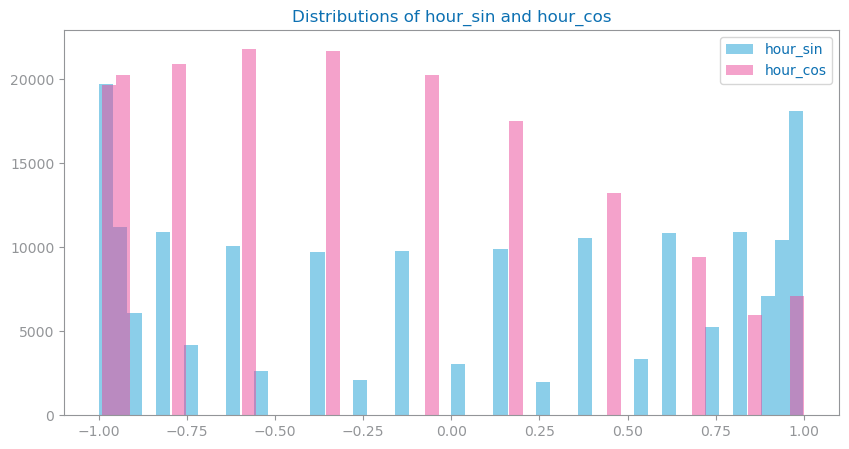

In [ ]:
## Out 1 strategy aplication

## Out 1  - Truncating outliers



## Out 1 strategy aplication

In [109]:
from pandas import DataFrame
from dslabs_functions import (
    NR_STDEV,
    get_variable_types,
    determine_outlier_thresholds_for_var,
)

def apply_strategy_1(df: DataFrame, summary5: DataFrame) -> DataFrame:
    df_copy = df.copy()

    # Obter variáveis numéricas
    numeric_vars = get_variable_types(df_copy)["numeric"]
    
    if numeric_vars:
        print("Data before truncating outliers:", df.shape)
        
        for var in numeric_vars:
            # Calcular os limites de outlier para a variável usando summary5
            top, bottom = determine_outlier_thresholds_for_var(summary5[var])
            
            # Truncar outliers
            df_copy[var] = df_copy[var].apply(
                lambda x: top if x > top else bottom if x < bottom else x
            )
        
        print("Data after truncating outliers:", df_copy.shape)
    else:
        print("There are no numeric variables")
    
    return df_copy

# Usar a função
summary5 = df.describe()  # Calcular o resumo estatístico antes de chamar a função
df_1 = apply_strategy_1(df, summary5)



Data before truncating outliers: (177828, 18)
Data after truncating outliers: (177828, 18)


In [48]:
df_1.head()

,category_code_lvl_1,category_code_lvl_2,category_code_lvl_3,price,week_of_month,is_weekend,day,is_view,is_cart,is_purchase,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,min_sin,min_cos
0,6.0,42.0,102.0,128.45,0,0,0,1,0,0,0.0,1.0,1.0,0.0,0.817,-0.577,-0.000,1.000
2836,0.0,6.0,10.0,770.93,0,0,0,1,0,0,0.0,-1.0,1.0,0.0,-0.631,-0.776,0.899,-0.437
2837,0.0,0.0,2.0,316.53,0,0,0,1,0,0,0.0,1.0,1.0,0.0,0.398,-0.917,0.991,-0.133
2838,11.0,57.0,125.0,127.29,0,0,0,1,0,0,0.0,-1.0,1.0,0.0,-0.631,-0.776,1.000,-0.027
2839,5.0,38.0,90.0,743.91,0,0,0,1,0,0,0.0,-1.0,1.0,0.0,-0.998,-0.068,-0.638,-0.770


In [110]:

# Verificar quais colunas foram alteradas e coletar informações
altered_info = {}
for var in get_variable_types(df)["numeric"]:
    altered_indices = df.index[df[var] != df_1[var]].tolist()
    if altered_indices:
        altered_count = len(altered_indices)
        new_values = df_1.loc[altered_indices, var].to_list()
        altered_info[var] = {'altered_count': altered_count, 'new_values': new_values}

# Imprimir informações das colunas alteradas
for var, info in altered_info.items():
    print(f"Coluna '{var}' foi alterada. Número de linhas alteradas: {info['altered_count']}. Novos valores: {info['new_values']}")

Coluna 'price' foi alterada. Número de linhas alteradas: 8789. Novos valores: [993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.4229357195629, 993.42293

## Out 1 Target Prep

In [111]:
from numpy import array, ndarray

y_1, X_1, labels, values = define_target_and_prepare_data(df_1, target)


Labels=[0, 1]


## Out 1 train/test split 

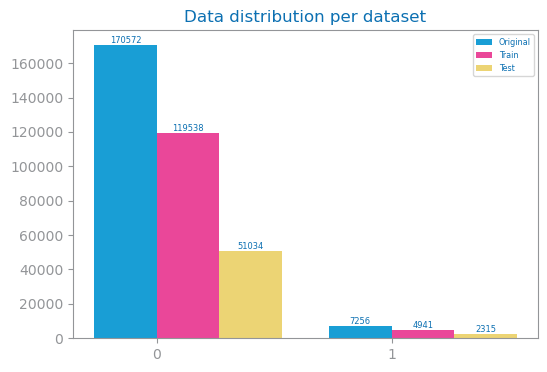

In [112]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from dslabs_functions import plot_multibar_chart


# Call the function to split the data
train_1, test_1 = split_data_save_csv(pd.DataFrame(X_1, columns=df_1.columns), y_1, data_columns=df_1.columns, target_column=target)

# Distribution check
values["Train"] = [
    len(train_1[train_1[target] == 0]),
    len(train_1[train_1[target] == 1]),
]
values["Test"] = [
    len(test_1[test_1[target] == 0]),
    len(test_1[test_1[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

## Out 1 evaluate

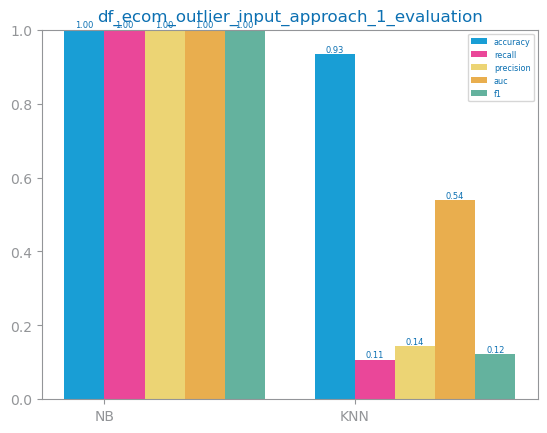

In [113]:
# evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
# removed Multinomial from run_NB function because dataset has negative values

figure()
eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='is_purchase', metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval_1, title=f"{file_tag}_approach_1_evaluation", percentage=True
)
savefig(f"images/{file_tag}_approach_1_evaluation.png")
show()

# Out 2 - drop outlier strategy


## Out 2 strategy aplication

In [114]:
from pandas import DataFrame, Series
from dslabs_functions import (
    NR_STDEV,
    get_variable_types,
    determine_outlier_thresholds_for_var,
)

def apply_strategy_2(df: DataFrame, summary5: DataFrame) -> DataFrame:
    df_copy = df.copy()

    # Obter variáveis numéricas
    numeric_vars = get_variable_types(df_copy)["numeric"]
    
    if numeric_vars:
        print("Data before dropping outliers:", df_copy.shape)


        for var in numeric_vars:
            # Calcular os limites de outlier para a variável usando summary5
            top, bottom = determine_outlier_thresholds_for_var(summary5[var])
            
            # Identificar os outliers
            outliers: Series = df_copy[(df_copy[var] > top) | (df_copy[var] < bottom)]
            # Armazenar informações sobre valores removidos

            # Remover outliers
            df_copy.drop(outliers.index, axis=0, inplace=True)
        
        print("Data after dropping outliers:", df_copy.shape)
    else:
        print("There are no numeric variables")
    
    return df_copy

# Usar a função
summary5 = df.describe()  # Calcular o resumo estatístico antes de chamar a função
df_2 = apply_strategy_2(df, summary5)

# Salvar o DataFrame resultante em um CSV, se necessário
# data_2.to_csv(f"data/{file_tag}_drop_outliers.csv", index=True)


Data before dropping outliers: (177828, 18)
Data after dropping outliers: (162369, 18)


## Out 2 target prep

In [115]:
y_2, X_2, labels, class_counts = define_target_and_prepare_data(df_2, target=target)


Labels=[0, 1]


In [117]:
print("Data after dropping outliers:", df_2.shape)

Data after dropping outliers: (162369, 17)


## Out 2 train/test split 

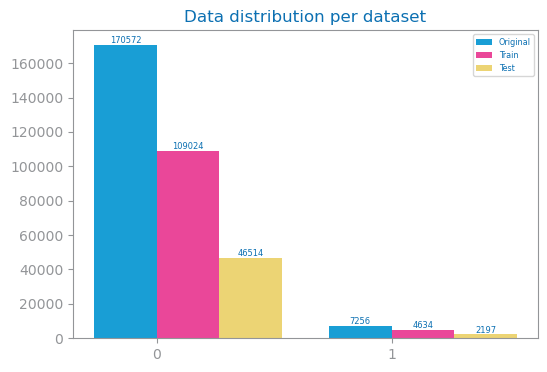

In [116]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from dslabs_functions import plot_multibar_chart


# Call the function to split the data
train_2, test_2 = split_data_save_csv(pd.DataFrame(X_2, columns=df_2.columns), y_2, data_columns=df_2.columns, target_column=target)

# Distribution check
values["Train"] = [
    len(train_2[train_2[target] == 0]),
    len(train_2[train_2[target] == 1]),
]
values["Test"] = [
    len(test_2[test_2[target] == 0]),
    len(test_2[test_2[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

## Out 2 evaluate

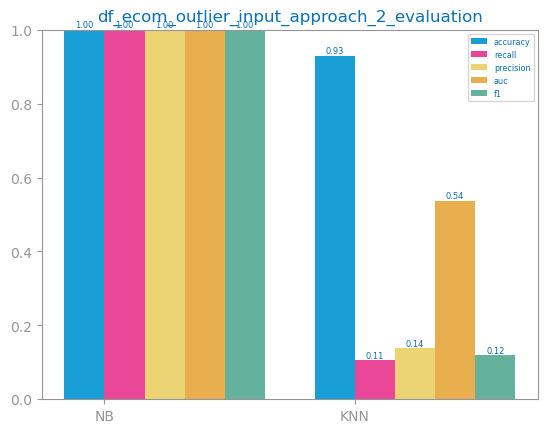

In [118]:

figure()
eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='is_purchase', metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval_2, title=f"{file_tag}_approach_2_evaluation", percentage=True
)
savefig(f"images/{file_tag}_approach_2_evaluation.png")
show()

# Approach uplift comparison

## uplift df

In [119]:
algorithms = ['Naive Bayes', 'KNN']

# Create DataFrames for eval_1 and eval_2
df_eval_1 = pd.DataFrame(eval_1, index=algorithms)
df_eval_2 = pd.DataFrame(eval_2, index=algorithms)

# Calculate uplift
df_uplift = df_eval_2 - df_eval_1



# Combine everything into one DataFrame (without misalignment issues)
comparison_df = pd.concat([df_eval_1, df_eval_2, df_uplift], axis=1)
comparison_df.columns = pd.MultiIndex.from_product([['Approach 1', 'Approach 2', 'Uplift'], eval_1.keys()])



# Display the DataFrame
comparison_df

Approach 1                                         Approach 2  \
              accuracy    recall precision       auc        f1   accuracy   
Naive Bayes   1.000000  1.000000  1.000000  1.000000  1.000000   1.000000   
KNN           0.933719  0.106695  0.144023  0.538965  0.122581   0.929872   

                                                       Uplift            \
               recall precision       auc        f1  accuracy    recall   
Naive Bayes  1.000000  1.000000  1.000000  1.000000  0.000000  0.000000   
KNN          0.105599  0.137849  0.537202  0.119588 -0.003847 -0.001097   

                                           
            precision       auc        f1  
Naive Bayes  0.000000  0.000000  0.000000  
KNN         -0.006174 -0.001763 -0.002993

# Analysis

Outlier treatment:
- In Outlier treatment, Approach 1 has better results than approach 2 
     -   Why?
      - it has better accuracy, better recall and better precision

Comparing with previous dataset:
- Considering approach 1 is the best between both strategies, if we compare between previous dataset and outlier treatment, we have:
     - Recall diminiu um pouco (- de 1%)
        - Precision aumentou 2%

Decision:
- Let's move one with approach 1 from outliers treatmeant because hase higher levels of precision than recall
- Datset choosen:
    - Df_1 : Approach - Replacing outliers with fixed value


# save to csv

In [120]:
if test_data==False:
    

    data_save=df.copy()

    # apply winning strategy
    data_save=apply_strategy_1(data_save,summary5)
        
    data_save.to_csv(f"dataset/df_ecom_2_3_outlier_input_v2_dummyfication.csv", index=False)
    
    print(data_save.columns)

Data before truncating outliers: (177828, 18)
Data after truncating outliers: (177828, 18)
Index(['category_code_lvl_1', 'category_code_lvl_2', 'category_code_lvl_3',
       'price', 'week_of_month', 'is_weekend', 'day', 'is_view', 'is_cart',
       'is_purchase', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos'],
      dtype='object')


## train test csv

In [121]:
if test_data==False:
    

    data_save_copy=data_save.copy()

    
    y, X, labels, class_counts = define_target_and_prepare_data(data_save_copy, target=target)

    train, test = split_data_save_csv(pd.DataFrame(X, columns=data_save_copy.columns), y, data_columns=data_save_copy.columns, target_column=target)  
    
    train.to_csv(f"dataset/df_ecom_2_3_outliers_input_train.csv", index=False)
    print(train.columns)
    
    test.to_csv(f"dataset/df_ecom_2_3_outliers_input_test.csv", index=False)
    print(test.columns)

Labels=[0, 1]
Index(['category_code_lvl_1', 'category_code_lvl_2', 'category_code_lvl_3',
       'price', 'week_of_month', 'is_weekend', 'day', 'is_view', 'is_cart',
       'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos',
       'is_purchase'],
      dtype='object')
Index(['category_code_lvl_1', 'category_code_lvl_2', 'category_code_lvl_3',
       'price', 'week_of_month', 'is_weekend', 'day', 'is_view', 'is_cart',
       'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos',
       'is_purchase'],
      dtype='object')
